NAME: BALAAPARAJITHA SENTHIL KUMAR

NIUB: 21886034

NAME: ABINAYA VINOTH

NIUB: 21886001

In [18]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

from prophet import Prophet

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    Flatten,
    Dense,
    Dropout,
    Input
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber, MeanAbsoluteError
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# Download NVDA stock data
data=pd.read_csv('/content/Nvidia.csv')

<Axes: title={'center': 'NVDA Closing Prices'}>

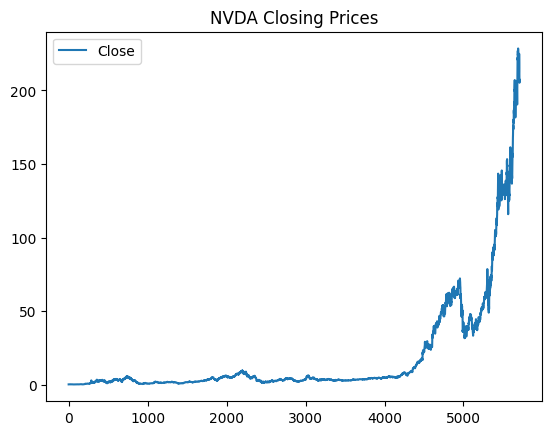

In [ ]:
data[['Close']].plot(title="NVDA Closing Prices")


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9vnmnxpk/ue2338me.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9vnmnxpk/7_62sjbe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83460', 'data', 'file=/tmp/tmp9vnmnxpk/ue2338me.json', 'init=/tmp/tmp9vnmnxpk/7_62sjbe.json', 'output', 'file=/tmp/tmp9vnmnxpk/prophet_model3_0k57s8/prophet_model-20250528120152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:01:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:01:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


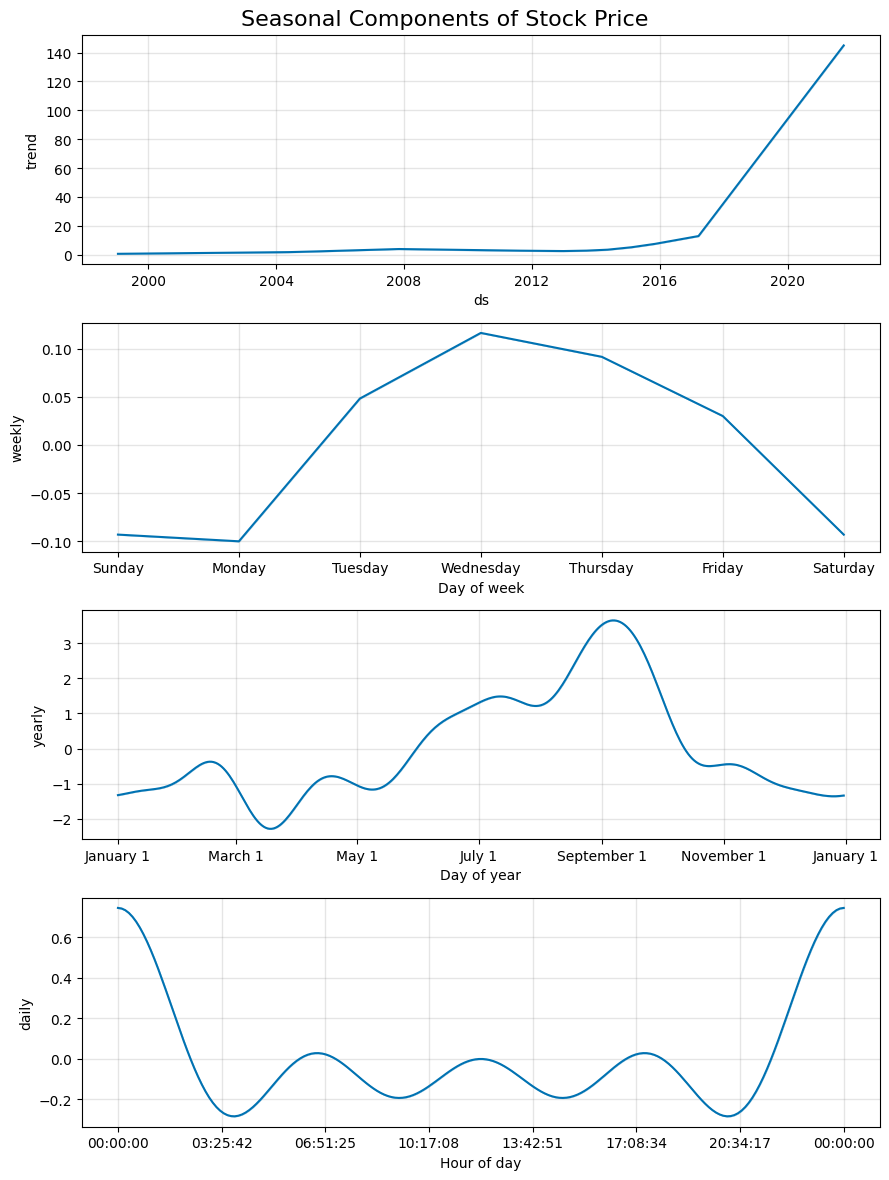

In [ ]:
df = data[['Date', 'Close']].copy()
df.columns = ['ds', 'y']

df['ds'] = pd.to_datetime(df['ds'])

model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True
)
model.fit(df)

future = model.make_future_dataframe(periods=0)

forecast = model.predict(future)
fig = model.plot_components(forecast)

plt.suptitle("Seasonal Components of Stock Price", fontsize=16)
plt.tight_layout()
plt.show()


In [4]:
def generate_spectrogram(series, nperseg=64):
    f, t, Sxx = signal.spectrogram(series, nperseg=nperseg)
    return Sxx

def create_spectrogram_images(prices, window_size=128, save_dir='spectrograms'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    images, labels = [], []
    for i in range(window_size, len(prices)-1):
        segment = prices[i-window_size:i]
        label = prices[i+1]
        spec = generate_spectrogram(segment)
        spec_resized = cv2.resize(spec, (64, 64))
        images.append(spec_resized)
        labels.append(label)
    return np.array(images), np.array(labels)

close_prices = data['Close'].values
images, labels = create_spectrogram_images(close_prices)

images = images / np.max(images)
images = images[..., np.newaxis]

max_label = np.max(labels)
labels = labels / max_label

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [ ]:
# Split training set again for validation
X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define hyperparameter grid
filters1_list = [16, 32]
filters2_list = [32, 64]
dense_units_list = [32, 64]
dropout_list = [0.3, 0.4]
lr_list = [1e-3, 1e-4]

# To track the best model
best_val_mae = float('inf')
best_model = None
best_params = {}

# Grid search loop
for f1 in filters1_list:
    for f2 in filters2_list:
        for d in dense_units_list:
            for dr in dropout_list:
                for lr in lr_list:
                    print(f"Training with filters1={f1}, filters2={f2}, dense_units={d}, dropout={dr}, lr={lr}")

                    model = Sequential()
                    model.add(Conv2D(f1, (3, 3), activation='relu', input_shape=(64, 64, 1)))
                    model.add(MaxPooling2D((2, 2)))
                    model.add(Conv2D(f2, (3, 3), activation='relu'))
                    model.add(MaxPooling2D((2, 2)))
                    model.add(GlobalAveragePooling2D())
                    model.add(Dense(d, activation='relu'))
                    model.add(Dropout(dr))
                    model.add(Dense(1))

                    model.compile(optimizer=Adam(learning_rate=lr), loss=Huber(), metrics=['mae'])

                    history = model.fit(
                        X_subtrain, y_subtrain,
                        validation_data=(X_val, y_val),
                        epochs=6,
                        batch_size=32,
                        verbose=0
                    )

                    val_mae = history.history['val_mae'][-1]

                    if val_mae < best_val_mae:
                        best_val_mae = val_mae
                        best_model = model
                        best_params = {
                            'filters1': f1,
                            'filters2': f2,
                            'dense_units': d,
                            'dropout': dr,
                            'lr': lr
                        }

print("\n Best Model Configuration:")
for k, v in best_params.items():
    print(f"{k}: {v}")
print(f"Best validation MAE: {best_val_mae:.4f}")


Training with filters1=16, filters2=32, dense_units=32, dropout=0.3, lr=0.001
Training with filters1=16, filters2=32, dense_units=32, dropout=0.3, lr=0.0001
Training with filters1=16, filters2=32, dense_units=32, dropout=0.4, lr=0.001
Training with filters1=16, filters2=32, dense_units=32, dropout=0.4, lr=0.0001
Training with filters1=16, filters2=32, dense_units=64, dropout=0.3, lr=0.001
Training with filters1=16, filters2=32, dense_units=64, dropout=0.3, lr=0.0001
Training with filters1=16, filters2=32, dense_units=64, dropout=0.4, lr=0.001
Training with filters1=16, filters2=32, dense_units=64, dropout=0.4, lr=0.0001
Training with filters1=16, filters2=64, dense_units=32, dropout=0.3, lr=0.001
Training with filters1=16, filters2=64, dense_units=32, dropout=0.3, lr=0.0001
Training with filters1=16, filters2=64, dense_units=32, dropout=0.4, lr=0.001
Training with filters1=16, filters2=64, dense_units=32, dropout=0.4, lr=0.0001
Training with filters1=16, filters2=64, dense_units=64, dr

In [ ]:
best_model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 62, 62, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,933 (81.77 KB)

 Trainable params: 6,977 (27.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,956 (54.52 KB)

In [6]:
# Build the CNN model
model = Sequential([
    Input(shape=(64, 64, 1)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=MeanAbsoluteError(),
    metrics=['mae']
)

# Print summary
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,977 (27.25 KB)

 Trainable params: 6,977 (27.25 KB)

 Non-trainable params: 0 (0.00 B)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


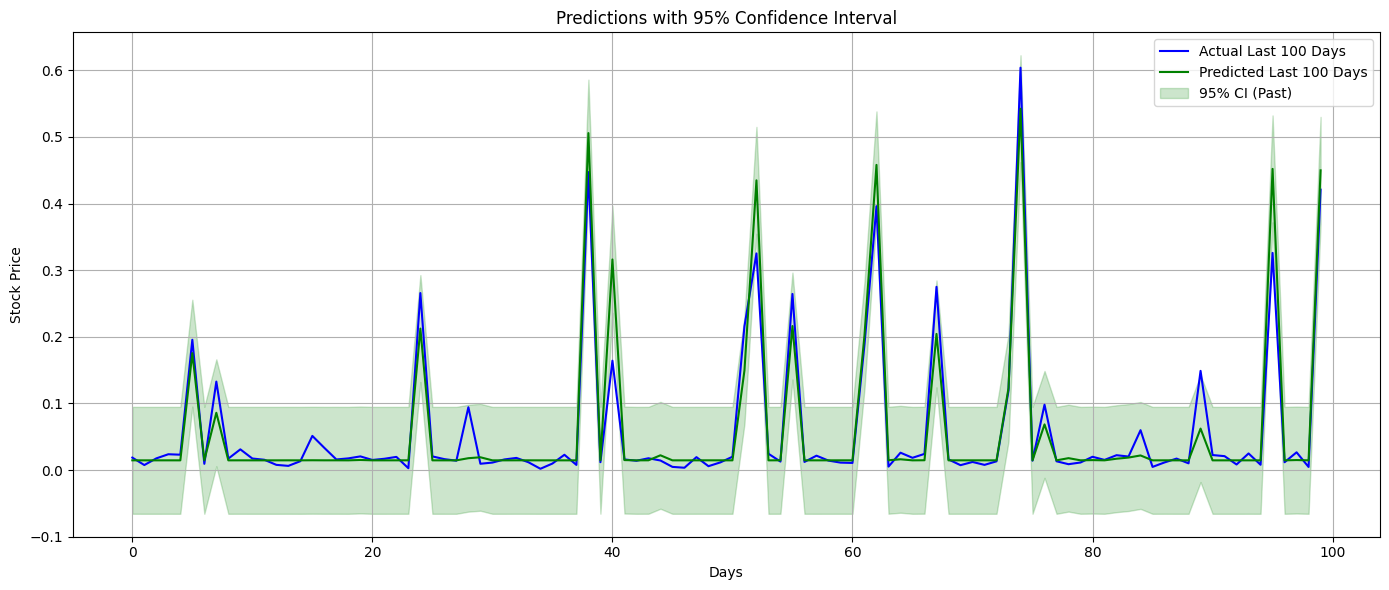

Mean Absolute Error (MAE): 0.0162
Root Mean Squared Error (RMSE): 0.0317
R² Score (Accuracy): 0.9172


In [11]:
#Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

last_100_X = X_test[-100:]
last_100_y_true = y_test[-100:]
last_100_y_pred = model.predict(last_100_X).flatten()

val_pred = model.predict(X_test).flatten()
val_residuals = y_test - val_pred
residual_std = np.std(val_residuals)

ci = 1.96 * residual_std
upper_bound_last100 = last_100_y_pred + ci
lower_bound_last100 = last_100_y_pred - ci

plt.figure(figsize=(14, 6))

plt.plot(range(100), last_100_y_true, label='Actual Last 100 Days', color='blue')
plt.plot(range(100), last_100_y_pred, label='Predicted Last 100 Days', color='green')


plt.fill_between(range(100), lower_bound_last100, upper_bound_last100, color='green', alpha=0.2, label='95% CI (Past)')

plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Predictions with 95% Confidence Interval')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(last_100_y_true, last_100_y_pred)
rmse = np.sqrt(mean_squared_error(last_100_y_true, last_100_y_pred))
r2 = r2_score(last_100_y_true, last_100_y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score (Accuracy): {r2:.4f}")


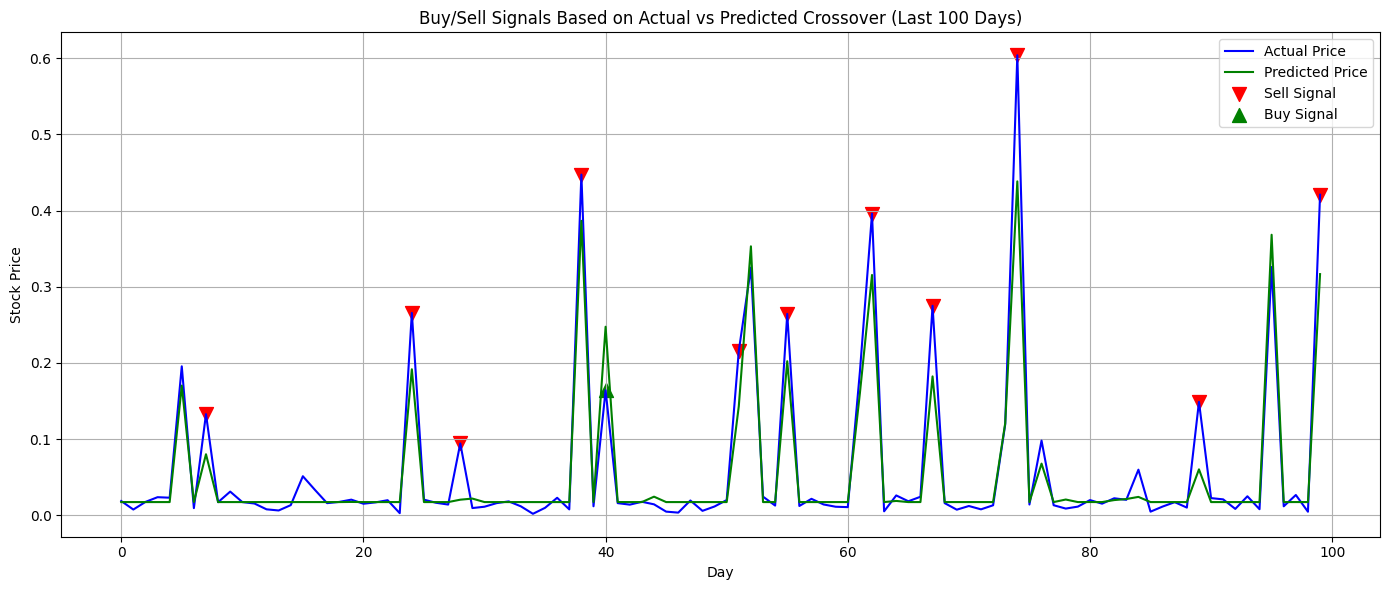

In [ ]:
images = images / np.max(images)
images = images[..., np.newaxis]
labels = labels / np.max(labels)
label_scaler = np.max(labels)

last_100_y_pred = last_100_y_pred * label_scaler
last_100_y_true = last_100_y_true * label_scaler
threshold = 0.05 * label_scaler
signals = ['Hold']

for i in range(1, len(last_100_y_pred)):
    prev_diff = last_100_y_pred[i-1] - last_100_y_true[i-1]
    curr_diff = last_100_y_pred[i] - last_100_y_true[i]

    if curr_diff > threshold and prev_diff <= threshold:
        signals.append('Buy')
    elif curr_diff < -threshold and prev_diff >= -threshold:
        signals.append('Sell')
    else:
        signals.append('Hold')

plt.figure(figsize=(14,6))
plt.plot(range(100), last_100_y_true, label='Actual Price', color='blue')
plt.plot(range(100), last_100_y_pred, label='Predicted Price', color='green')

for i, signal in enumerate(signals):
    if signal == 'Buy':
        plt.scatter(i, last_100_y_true[i], color='green', marker='^', s=100, label='Buy Signal' if i == signals.index('Buy') else "")
    elif signal == 'Sell':
        plt.scatter(i, last_100_y_true[i], color='red', marker='v', s=100, label='Sell Signal' if i == signals.index('Sell') else "")

plt.title("Buy/Sell Signals Based on Actual vs Predicted Crossover (Last 100 Days)")
plt.xlabel("Day")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**MODEL WITH DATA AUGMENTATION**

In [12]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

In [13]:
# Build the CNN model
model = Sequential([
    Input(shape=(64, 64, 1)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=MeanAbsoluteError(),
    metrics=['mae']
)

# Print summary
model.summary()



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,977 (27.25 KB)

 Trainable params: 6,977 (27.25 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - loss: 0.0803 - mae: 0.0803 - val_loss: 0.0509 - val_mae: 0.0509
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - loss: 0.0492 - mae: 0.0492 - val_loss: 0.0396 - val_mae: 0.0396
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - loss: 0.0462 - mae: 0.0462 - val_loss: 0.0425 - val_mae: 0.0425
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.0433 - mae: 0.0433 - val_loss: 0.0410 - val_mae: 0.0410
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.0416 - mae: 0.0416 - val_loss: 0.0368 - val_mae: 0.0368
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 75ms/step - loss: 0.0396 - mae: 0.0396 - val_loss: 0.0336 - val_mae: 0.0336
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - loss: 0.0371 - mae: 0.0371 - val_loss: 0.0295 - val_mae: 0.0295
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 0.0345 - mae: 0.0345 - val_loss: 0.0282 - val_mae: 0.0282
Epoch 9/10
112/112 ━━━━━━━━━━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


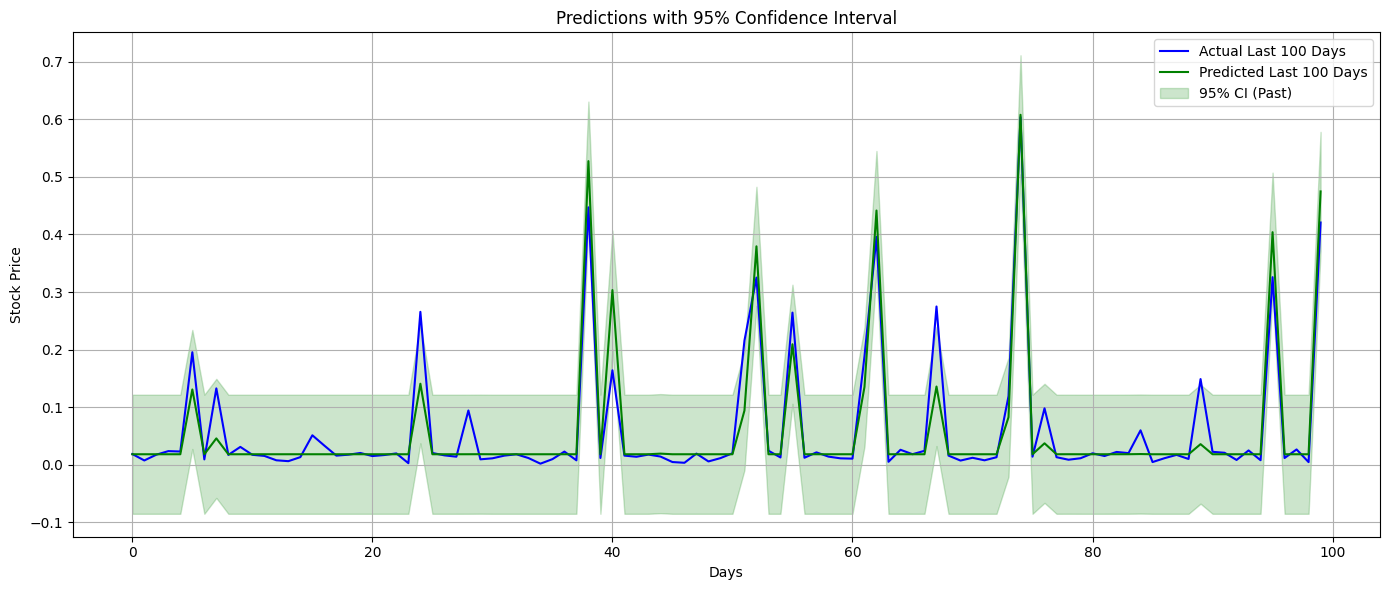

Accuracy Metrics for Last 100 Days:
 Mean Absolute Error (MAE): 0.0195
Root Mean Squared Error (RMSE): 0.0372
R² Score: 0.8865


In [15]:
# Predict last 100 days
last_100_X = X_test[-100:]
last_100_y_true = y_test[-100:]
last_100_y_pred = model.predict(last_100_X).flatten()

# Compute residual std from validation predictions
val_pred = model.predict(X_test).flatten()
val_residuals = y_test - val_pred
residual_std = np.std(val_residuals)

# 95% confidence interval: ±1.96 * std
ci = 1.96 * residual_std
upper_bound_last100 = last_100_y_pred + ci
lower_bound_last100 = last_100_y_pred - ci

# Plot with confidence intervals
plt.figure(figsize=(14, 6))

# Plot actual and predicted for last 100 days
plt.plot(range(100), last_100_y_true, label='Actual Last 100 Days', color='blue')
plt.plot(range(100), last_100_y_pred, label='Predicted Last 100 Days', color='green')

# Confidence interval shading
plt.fill_between(range(100), lower_bound_last100, upper_bound_last100, color='green', alpha=0.2, label='95% CI (Past)')

# Labels and formatting
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Predictions with 95% Confidence Interval')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Compute accuracy metrics
mae = mean_absolute_error(last_100_y_true, last_100_y_pred)
rmse = np.sqrt(mean_squared_error(last_100_y_true, last_100_y_pred))
r2 = r2_score(last_100_y_true, last_100_y_pred)

# Print results
print("Accuracy Metrics for Last 100 Days:")
print(f" Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


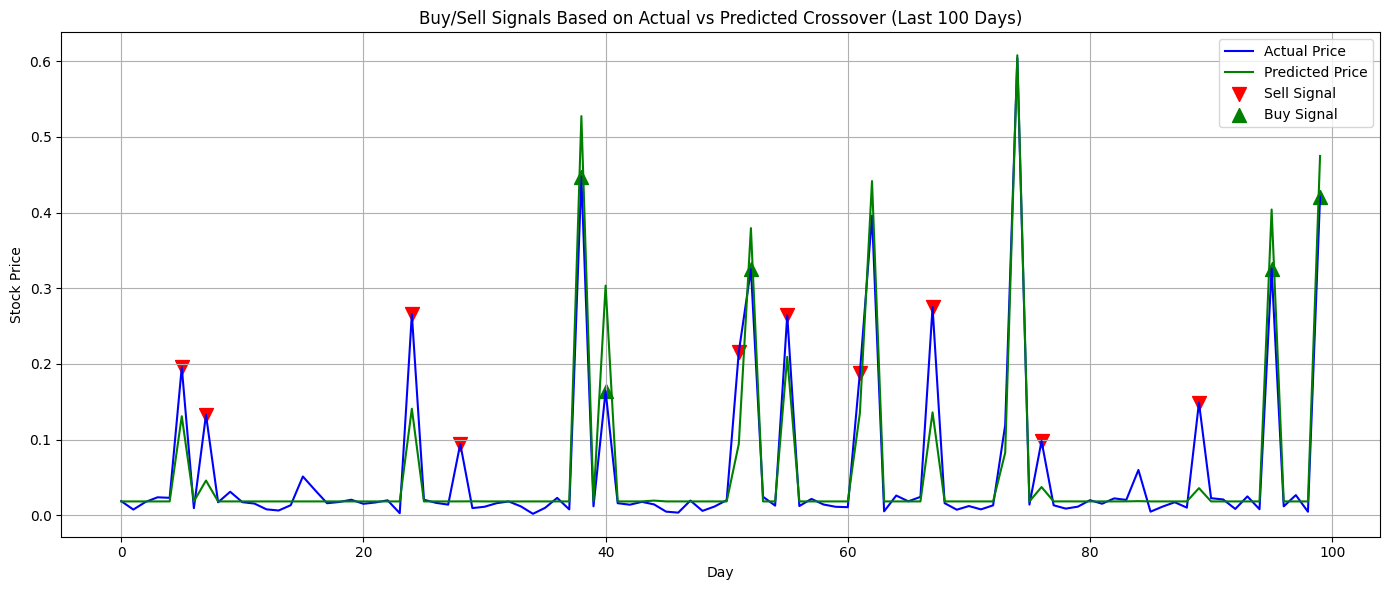

In [16]:
images = images / np.max(images)
images = images[..., np.newaxis]
labels = labels / np.max(labels)
label_scaler = np.max(labels)

last_100_y_pred = last_100_y_pred * label_scaler
last_100_y_true = last_100_y_true * label_scaler
threshold = 0.05 * label_scaler
signals = ['Hold']

for i in range(1, len(last_100_y_pred)):
    prev_diff = last_100_y_pred[i-1] - last_100_y_true[i-1]
    curr_diff = last_100_y_pred[i] - last_100_y_true[i]

    if curr_diff > threshold and prev_diff <= threshold:
        signals.append('Buy')
    elif curr_diff < -threshold and prev_diff >= -threshold:
        signals.append('Sell')
    else:
        signals.append('Hold')

plt.figure(figsize=(14,6))
plt.plot(range(100), last_100_y_true, label='Actual Price', color='blue')
plt.plot(range(100), last_100_y_pred, label='Predicted Price', color='green')


for i, signal in enumerate(signals):
    if signal == 'Buy':
        plt.scatter(i, last_100_y_true[i], color='green', marker='^', s=100, label='Buy Signal' if i == signals.index('Buy') else "")
    elif signal == 'Sell':
        plt.scatter(i, last_100_y_true[i], color='red', marker='v', s=100, label='Sell Signal' if i == signals.index('Sell') else "")

plt.title("Buy/Sell Signals Based on Actual vs Predicted Crossover (Last 100 Days)")
plt.xlabel("Day")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()